In [1]:
from scipy.stats import multivariate_normal as mult_gauss
import numpy as np
import random
from numpy import linalg as LA
import sklearn as sklearn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pylab import *
from sklearn.cluster import KMeans
# %matplotlib qt

## The Expectation Maximization algorithm for a Gaussian mixture model is implemented as follows:

In [2]:
class EM_Gaussian_Misture(object):
    
    def __init__(self, X_data, K, tol):
        self.X_Data = X_data                       # X_data has dimension in the rows and observations in the coloumns
        self.K = K                                 # Mixture size
        self.d, self.N = self.X_Data.shape              # find the shape of the data
        self.gam = np.zeros((self.N,self.K))            # initialize all gammas as zero
        
        kmeans = KMeans(n_clusters=self.K, random_state=1).fit(self.X_Data.T)
        lables = kmeans.labels_
        unique, counts = np.unique(lables, return_counts=True)
        
#         self.pi = np.random.uniform(0,1,self.K)         # initialize the contributions
        self.pi = np.array(counts)/self.N
#         self.mu = np.random.random((self.d,self.K))     # initialize the means
        self.mu = np.array(kmeans.cluster_centers_).T
        self.sigma =  np.array([np.eye(self.d)]*self.K) # initialize the covariances
        self.tol = tol
        

    def E_step(self):  # compute the posteriori probabilities
        for i in range(self.N):
            for j in range(self.K):
                self.gam[i,j] = self.pi[j]*mult_gauss(self.mu[:,j], self.sigma[j,:,:]).pdf(self.X_Data[:,i]) # first find the numerator for all n's in N and k's in K
        sumd = self.gam.sum(1)     # to find the denominatior sum over all k's for a n in N
        self.gam = self.gam.T/sumd # find the posterior probabilities  
        return self.gam.T 
    
    def M_step(self):
        self.gam = self.E_step()  # get the gammas 
        N_k = self.gam.sum(0)    # compute Nk by summing all the rows of gamma
        
        self.pi = N_k/self.N     # compute pi
        
        self.mu = np.dot(self.gam.T, self.X_Data.T)
        self.mu = self.mu.T/N_k  # compute mu       
        
        for i in range(self.K):                    # compute sigma
            for j in range(self.N):
                dum = np.reshape((self.X_Data[:,j] -  self.mu[:,i]), (self.d,1)) # compute (X_n-mu_n)
                self.sigma[i,:,:] += self.gam[j,i]*np.dot(dum, dum.T)           # compute (X_n-mu_n)(X_n-mu_n)^T
            self.sigma[i,:,:] = self.sigma[i,:,:]/N_k[i]  # divide sigma of each mixture by N_k to compute sigma
        
        return self.pi, self.gam, self.mu, self.sigma
    
    def EM_Gauss(self):  # to compute log-likelihood and check convergence
        error = 10
        l_old = 0
        iter = 0
        while error>self.tol:
            
            self.pi, self.gam, self.mu, self.sigma = self.M_step()

            l_new = 0.0
            for i in range(self.N):
                dum = 0.0
                for j in range(self.K):
                    dum += self.pi[j]*mult_gauss(self.mu[:,j], self.sigma[j,:,:]).pdf(self.X_Data[:,i])
                dum = np.log(dum)
                l_new += dum

            error = abs(l_new-l_old)
            l_old = l_new        
            print('iter =', iter, ', error = ', error)
            iter += 1
        return np.array(self.pi), np.array(self.mu), np.array(self.sigma)

## Generate data

In [3]:
# def generate_data(mean, cov, pii, N):
def generate_data(generators, N, pi):
#     X_data = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*N))
#                     for pi, mu, sigma in zip(pii, mean, cov)])
    draw = np.random.choice([0, 1, 2], N, p=pi.tolist())
    unique, counts = np.unique(draw, return_counts=True)
    
    mixture_info = (dict(zip(unique, counts)))
    
    X_Data = [np.array(generators[i].rvs()) for i in draw]
    X_Data = np.array(X_Data)
    return X_Data.T, mixture_info

def ploting(X_Data):

    if X_Data.shape[1] == 2:
        fig, ax = plt.subplots(num=1, clear=True)
        handle = ax.plot(X_Data[:,0], X_Data[:,1], '.')
        plt.axis('equal')
#         plt.show()
        
    elif X_Data.shape[1] == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(X_Data[:,0], X_Data[:,1], X_Data[:,2], '.')
        
    else:
        print("Can't plot dimension > 3 !!!")

    return None

## Estimate the parametrs

In [4]:
## ------ 2D data generation ------------ ##
pi = np.array([0.4, 0.3, 0.3])
generators = [
    mult_gauss([-10, 10], [[5, 0], [0, 7]]),             
    mult_gauss([2, -5], [[10, 0], [0, 3]]), 
    mult_gauss([1, 1], [[5, 0], [0, 15]])]

## ------ 3D data generation ------------ ##
# mean = np.array([[20,10,1], [-22,15,10], [-30, 10,1]])
# cov = np.array([[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[2,0,0],[0,2,0], [0,0,2]], [[3,0,0],[0,3,0],[0,0,3]] ])
# pi = np.array([0.3, 0.2, 0.1])




N = 1000
K = 3
tol = 0.0000001
Data, mixture_info =  generate_data(generators, N, pi)
# X_data = input("Input X_data:")
# print(Data.shape)

X_Data = Data

obj = EM_Gaussian_Misture(X_Data, K, tol)
pi_hat, mu_hat, sigma_hat = obj.EM_Gauss()

print('\n ----------------- The converged parametrs are ----------------- \n')
print('pi_hat = \n', pi_hat, '\n')
print('mu_hat = \n', mu_hat, '\n')
print('Sigma_hat = \n', sigma_hat, '\n')

iter = 0 , error =  5651.731398446278
iter = 1 , error =  4.7593437000241465
iter = 2 , error =  1.3538327363685312
iter = 3 , error =  0.8139821785662207
iter = 4 , error =  0.6301046466232947
iter = 5 , error =  0.5237546928447046
iter = 6 , error =  0.4444594724700437
iter = 7 , error =  0.38052784537103435
iter = 8 , error =  0.3281910528176013
iter = 9 , error =  0.28541536583907146
iter = 10 , error =  0.2506192482305778
iter = 11 , error =  0.22244189040793572
iter = 12 , error =  0.19971630032341636
iter = 13 , error =  0.18146329878709366
iter = 14 , error =  0.16687580664802226
iter = 15 , error =  0.15529489575237676
iter = 16 , error =  0.14618282678202377
iter = 17 , error =  0.13909660352055653
iter = 18 , error =  0.13366374427914707
iter = 19 , error =  0.12956091058913444
iter = 20 , error =  0.1264956529976189
iter = 21 , error =  0.12419160481931613
iter = 22 , error =  0.12237777201698918
iter = 23 , error =  0.1207829176537416
iter = 24 , error =  0.119136185689967

## Validate, visualize, and compare with original data:


In [5]:
generators_hat = [
    mult_gauss(mu_hat[:,0], sigma_hat[0,:,:]),             
    mult_gauss(mu_hat[:,1], sigma_hat[1,:,:]), 
    mult_gauss(mu_hat[:,2], sigma_hat[2,:,:])]

X_Data_hat, mixture_info_hat =  generate_data(generators_hat, N, pi_hat)

### 1. Check if the Covarinaces are symmetric and positive definite:

In [6]:
print(sigma_hat.shape)
for i in range(sigma_hat.shape[0]):
    ev, evec = LA.eig(sigma_hat[i,:,:])
    print('Sigma_hat_' + str(i),'= \n',sigma_hat[i,:,:],' \n Eignevalues of Sigma_hat_'+str(i),'=',ev, '\n')

(3, 2, 2)
Sigma_hat_0 = 
 [[5.34311584 0.19602214]
 [0.19602214 7.45139834]]  
 Eignevalues of Sigma_hat_0 = [5.32504514 7.46946904] 

Sigma_hat_1 = 
 [[11.46189578  0.16776646]
 [ 0.16776646  2.49335061]]  
 Eignevalues of Sigma_hat_1 = [11.46503294  2.49021346] 

Sigma_hat_2 = 
 [[ 5.04057174  0.37195782]
 [ 0.37195782 16.72952072]]  
 Eignevalues of Sigma_hat_2 = [ 5.02874751 16.74134495] 



### 2. Check if the mixture size of the original data and the data generated by the estimated parameters are close:

In [7]:
print('mixture info of the original data: \n', 'pi=', pi,'\n','mixture_info = ', mixture_info, '\n')
print('mixture info of the estimated data: \n', 'pi_hat=', pi_hat,'\n','mixture_info = ', mixture_info_hat, '\n')


mixture info of the original data: 
 pi= [0.4 0.3 0.3] 
 mixture_info =  {0: 382, 1: 315, 2: 303} 

mixture info of the estimated data: 
 pi_hat= [0.38226867 0.28231283 0.3354185 ] 
 mixture_info =  {0: 375, 1: 292, 2: 333} 



### 3. Plot the original data and the data generated by the estimated parameters:

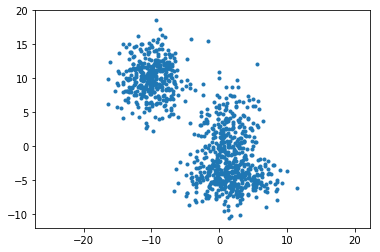

In [8]:
ploting(X_Data.T)

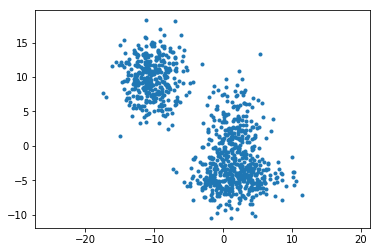

In [9]:
ploting(X_Data_hat.T)

In [10]:
print(X_Data.shape)
kmeans = KMeans(n_clusters=3, random_state=1).fit(X_Data.T)
lables = kmeans.labels_
print(np.array(kmeans.cluster_centers_).T)

(2, 1000)
[[-9.99119207  1.69987093  1.28095609]
 [10.04329178 -4.63510464  2.66388133]]


In [11]:
unique, counts = np.unique(lables, return_counts=True)
mixture_info = (((unique, counts)))

# print(np.array(np.asarray(mixture_info)))
print(counts)

[383 403 214]
